In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import pickle as pkl
import gzip

import games
import synthetic_data
import evaluator

import neuralcbp_EE_kclasses_v2
import neuralcbp_EE_kclasses_v3
import neuralcbp_EE_kclasses_v4
import neuralcbp_EE_kclasses_v5
import neuralcbp_EE_kclasses_v6
import ineural_multi
import neuronal
import margin_based
import cesa_bianchi

In [6]:


case = 'case2'
model = 'MLP'
approach = 'neuronal3'
context_type = 'MNIST'
n_folds = 1
horizon = 500
seed = 1


if case == 'case1':
    game = games.game_case1( {} )
    game.informative_symbols = [0, 1]
elif case == 'case2':
    game = games.game_case2( {} )
    game.informative_symbols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]
elif case == 'case3':
    game = games.game_case3( {} )
    game.informative_symbols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]
elif case == 'case4':
    game = games.game_case4( {} )
    game.informative_symbols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]


eval = evaluator.Evaluation(case, model, n_folds, horizon, game, approach, context_type)
eval.set_random_seeds(seed)


################################### CONTEXT GENERATOR:

if context_type == 'MNIST':
    if case == 'case1': 
        context_generator = synthetic_data.MNISTcontexts_binary(eval)
    else:
        context_generator = synthetic_data.MNISTcontexts(eval)
else:
    print('error')


################################### AGENT:

m = 100
nclasses = game.M

# if approach == 'EEneuralcbpside_v2':
#     alg = neuralcbp_EE_kclasses_v2.CBPside( game, 1.01, m, nclasses,  'cuda:0')
# elif approach == 'EEneuralcbpside_v3':
#     alg = neuralcbp_EE_kclasses_v3.CBPside( game, 1.01, m, nclasses,  'cuda:0')
# elif approach == 'EEneuralcbpside_v4':
#     alg = neuralcbp_EE_kclasses_v4.CBPside( game, 1.01, m, nclasses,  'cuda:0')
# elif approach == 'EEneuralcbpside_v5':
#     alg = neuralcbp_EE_kclasses_v5.CBPside( game, 1.01, m, nclasses,  'cuda:0')


if approach == 'EEneuralcbpside_v6':
    alg = neuralcbp_EE_kclasses_v6.CBPside( game, eval.model, 1.01, m, nclasses,  'cuda:0')

elif approach == 'ineural3':
    budget = eval.horizon
    margin = 3
    alg = ineural_multi.INeurALmulti(budget, nclasses, margin, m, 'cuda:0')

elif approach == 'ineural6':
    budget = eval.horizon
    margin = 6
    alg = ineural_multi.INeurALmulti(budget, nclasses, margin, 'cuda:0')


elif approach == 'neuronal3':
    budget = eval.horizon
    margin = 3
    alg = neuronal.NeuronAL(eval.model, budget, nclasses, margin, m,'cuda:0')

elif approach == 'neuronal6':
    budget = eval.horizon
    margin = 6
    alg = neuronal.NeuronAL(eval.model, budget, nclasses, margin, m, 'cuda:0')

elif approach == 'margin':
    threshold = 0.1
    alg = margin_based.MarginBased(game, m, threshold,  'cuda:0')

elif approach == 'cesa':
    alg = cesa_bianchi.CesaBianchi(game, m, 'cuda:0')

# job = context_generator, alg 
# evaluator.eval_policy_once( game, job )  
        
context_generator.initiate_loader()
alg.reset(context_generator.d)

In [7]:
job = context_generator, alg 
eval.eval_policy_once(game, job)

Parameter containing:
tensor([[ 0.0184, -0.0158, -0.0069,  ...,  0.0068, -0.0041,  0.0025],
        [-0.0274, -0.0224, -0.0309,  ..., -0.0029,  0.0013, -0.0167],
        [ 0.0282, -0.0095, -0.0340,  ..., -0.0141,  0.0056, -0.0335],
        ...,
        [-0.0170, -0.0294, -0.0351,  ..., -0.0320, -0.0291, -0.0083],
        [ 0.0207, -0.0126,  0.0167,  ..., -0.0350, -0.0347, -0.0292],
        [ 0.0182,  0.0104,  0.0114,  ..., -0.0278, -0.0205,  0.0123]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0056,  0.0040, -0.0308, -0.0345,  0.0084, -0.0259,  0.0295, -0.0229,
        -0.0203, -0.0179, -0.0321, -0.0261,  0.0189,  0.0013,  0.0144, -0.0104,
        -0.0077, -0.0096,  0.0133, -0.0082, -0.0144, -0.0169, -0.0137, -0.0082,
        -0.0327, -0.0097, -0.0091,  0.0308, -0.0055, -0.0295,  0.0208,  0.0296,
         0.0119,  0.0038, -0.0169, -0.0276, -0.0348,  0.0008,  0.0199,  0.0276,
         0.0239,  0.0327,  0.0203,  0.0150,  0.0090, -0.0232,  0.0189, -0.0223

True

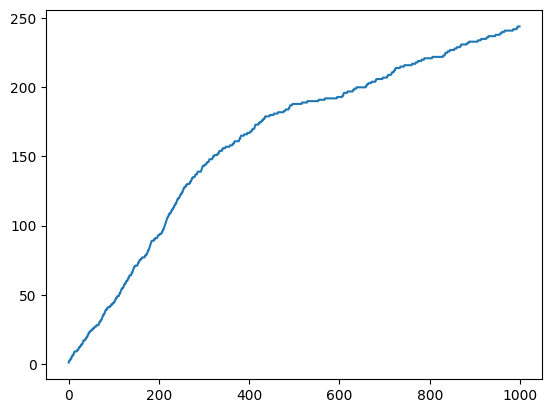

In [5]:
plt.plot(range(horizon), np.cumsum(cumRegret) )

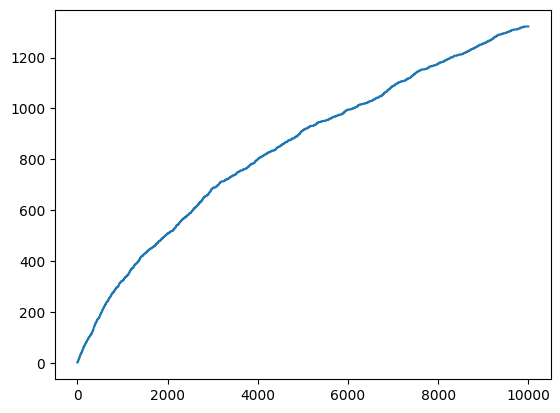

In [5]:
plt.plot(range(horizon), np.cumsum(cumRegret) )

In [ ]:
plt.plot(range(horizon), np.cumsum(cumRegret) )

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.measure import block_reduce

class Network_exploitation(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=100):
        super(Network_exploitation, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))
    
    
class Network_exploration(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=100):
        super(Network_exploration, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

def EE_forward(net1, net2, x):

    x.requires_grad = True
    f1 = net1(x)
    net1.zero_grad()
    f1.sum().backward(retain_graph=True)
    dc = torch.cat([p.grad.flatten().detach() for p in net1.parameters()])
    #dc = dc / torch.linalg.norm(dc)
    dc = block_reduce(dc.cpu(), block_size=51, func=np.mean)
    dc = torch.from_numpy(dc).to(x.device)
    # print('dc shape', dc.shape)
    f2 = net2(dc)
    return f1, f2, dc

game = games.game_case1( {} )

m = 100
d =  784

x = torch.ones((1,d)).to('cuda:0')

input_dim = d
output_dim = 2
net1 = Network_exploitation(input_dim, output_dim, m).to('cuda:0')

input_dim = 1544 #1660
output_dim = 2
net2 = Network_exploration(input_dim, output_dim, m).to('cuda:0')


f1, f2, dc  = EE_forward(net1, net2, x)
print(f1.shape)
print(f2.shape)
print(dc.shape)


In [39]:




game = games.game_case1( {} )

m = 100
d =  784

x = torch.ones( (1,28,28) ).float().to('cuda:0')

input_dim = d
output_dim = 10
net1 = Network_exploitation(output_dim,).to('cuda:0')


pred, latent = net1(x)
input_dim = 1330#1317 #1660
output_dim = 10
net2 = Network_exploration(input_dim, output_dim, m).to('cuda:0')

f1, f2, dc  = EE_forward(net1, net2, x)
print(f1.shape)
print(f2.shape)
print(dc.shape)


dc (1210,)
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 1330])


In [ ]:
# game.informative_symbols = [0, 1]

# def convert_pred_format(pred):
#     print('pred', pred)
#     final = []
#     for k in range(game.N):
#         print('k', k)
#         per_action = []
#         for s in np.unique(game.FeedbackMatrix[k]):
#             print('s', s)
#             if s in game.informative_symbols:
#                 per_action.append( pred[0][s].detach().cpu() )
#             else:
#                 per_action.append( 1 )
#         final.append( np.array(per_action) )
#     return final

# def convert_conf_format(conf, ):
#     final = []
#     for k in range(game.N):
#         per_action = []
#         for s in np.unique(game.FeedbackMatrix[k]):
#             if s in game.informative_symbols:
#                 per_action.append( conf[s].detach().cpu()  )
#             else:
#                 per_action.append( 0 )
#         final.append( np.array([max(per_action)]) )
#     return final

# pr = convert_pred_format(f1)
# print(pr)
# pr = convert_conf_format(f2)
# print(pr)

In [ ]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0.15

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i[4]) for i in train_hist ] ).squeeze(1) 

action0 = [ i[0] if i[0]==2 else np.nan for i in train_hist ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]

action1 = [ i[0] if i[0]==1 else np.nan for i in train_hist ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

action2 = [ i[0] if i[0]==0 else np.nan for i in train_hist ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

# plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange', markersize = 2, label = 'predicted as class 1')
# plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue', markersize = 2, label = 'predicted as class 2')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green', markersize = 2, label = 'explored')

plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
# plt.title('Training decision boundary (shift = {})'.format(b))
plt.title('Deployment decision boundary (shift = {})'.format(b))
plt.legend(loc = (-0.4,-0.25),ncol = 3)
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/CBP_DB_{}.png'.format(b), dpi=380, bbox_inches='tight')
plt.savefig('./figures/ETC_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')

In [ ]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0.15]: #[0, 0.15]

    plt.figure(figsize=(4, 4))

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i[4]) for i in depl_hist ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==2 else np.nan for i in depl_hist ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    action1 = [ i[0] if i[0]==1 else np.nan for i in depl_hist ]
    indices_action1 = np.where(~np.isnan(action1))[0]
    contexts1 = contexts[indices_action1]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', markersize = 1, color = 'red')
    plt.plot(contexts1[:,0], contexts1[:,1], '.', markersize = 1, color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('Deployment decision boundary (shift = {})'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    plt.savefig('./figures/ETC_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')
    # plt.savefig('./figures/CBP_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(np.cumsum(cumRegret))
# plt.ylim((0,3000))
# plt.savefig('./figures/ETC_regret3.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret3.png', dpi=380, bbox_inches='tight')

In [ ]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

# custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


In [ ]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.vstack( [ i for i in global_losses if len(i)>0 ] )

plt.figure(figsize=(8, 4))

plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, 19000) )

plt.xticks(custom_ticks, custom_tick_labels, rotation=45)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss[:,0], label = 'symbole 0' )
plt.plot( new_global_loss[:,1], label = 'symbole 1' )
plt.plot( new_global_loss[:,2], label = 'symbole 2' )
plt.plot( new_global_loss[:,3], label = 'symbole 3' )

plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./figures/loss_evolution_{}.png'.format(idx), dpi=380, bbox_inches='tight')


In [ ]:


def obtain_probability(t , factor):

    K = 100
    # sigma = K/(t+1)**(1/2)
    sigma = K/np.log(t+1)
    epsilon = 10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -rhos[i]**2 / ( 2*(sigma**2) )  )  for i in range(len(rhos)-1) ] )
    p_m = ( (1 - epsilon) * p_m_hat ) / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 10000):
    sigma_i = 2
    d = 730
    N = 3
    H = 1
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,10000), deterministic, '.', markersize = 1)

plt.plot(range(1,10000), rand, '.', markersize = 1)

plt.savefig('vara2k100.png')

In [ ]:
plt.hist(rand, bins = 10)

In [ ]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()